# Exploring OSRM, OSMnx, and Google Maps Directions API for finding routes between a set of origin-destination pairs.

In this notebook, I explore three of the routing libraries for calculating routes for a set of origin and destination pairs in one go, along with information such as travel distances and travel times along these routes. Based on your use case, you can pick which one works best for you. Also check out each of their documentation pages to know about more options for each.


# 1. OSRM to find fastest paths

OSRM is particularly useful when you want a free and open-source routing service and do not want to work with the street networks per se. For more services by OSRM head to its [documentation](http://project-osrm.org/docs/v5.23.0/api/#nearest-service). You can also set up your own OSRM server for bulkier requests. If you end up using OSRM in your project, do send them some love <3.

Do note that this service returns fastest routes, and not the shortest. Also note that it does not account for traffic conditions in its travel time estimates (at least as of the time of this writing). 

In [8]:
#general libraries

from shapely.geometry import shape
from shapely.geometry import LineString
import polyline
from osgeo import ogr, osr
import geopandas as gpd
import pandas as pd
import time


#specific to osrm approach
import requests

#specific to osmnx & networkx approach
import networkx as nx
import osmnx as ox

#specific to googlemaps approach
import googlemaps

#import folium

Used the get_route() method discussed by Michael Yan [here](https://www.thinkdatascience.com/post/2020-03-03-osrm/osrm/), and added 'duration' attribute as well, in the output dictionary. For more options such as alternative routes, mode of transportation (driving, bike, foot) i.e. the speed profile, do have a look at the OSRM documentation. In this example, I use [driving (car)](https://github.com/Project-OSRM/osrm-backend/blob/master/profiles/car.lua) speeds profile. You can also create your own speed profiles.

In [2]:
#Method to send requests to OSRM server and parse the json response to collect distance, duration, and route information 
#and return a dictionary
def get_route(origin_lon, origin_lat, dest_lon, dest_lat):
    
    loc = "{},{};{},{}".format(origin_lon, origin_lat, dest_lon, dest_lat)
    url = "http://router.project-osrm.org/route/v1/driving/"
    r = requests.get(url + loc) 
    if r.status_code!= 200:
        return {}
  
    res = r.json()   
    routes = polyline.decode(res['routes'][0]['geometry'])
    start_point = [res['waypoints'][0]['location'][1], res['waypoints'][0]['location'][0]]
    end_point = [res['waypoints'][1]['location'][1], res['waypoints'][1]['location'][0]]
    distance = res['routes'][0]['distance']
    duration = res['routes'][0]['duration']
    
    out = {'route':routes, #route is a list of tuples
           'start_point':start_point, #list of float coords
           'end_point':end_point,
           'distance':distance, #in metres
           'duration': duration #in seconds
          }

    return out

In [3]:
def reverseTuple(lstOfTuple): 
      
    return [tup[::-1] for tup in lstOfTuple]

#extract_route method parses the list of coordinates in the routes and generates the route geometry essential for outputting features
def extract_route(routes_dict):
    route_coords_list= routes_dict['route']    
    listnew = reverseTuple(route_coords_list)    
    return(LineString(listnew))

def extract_duration(routes_dict):
    return(routes_dict['duration'])

def extract_distance(routes_dict):
    return(routes_dict['distance'])

#You can also wrap above 3 methods into a single one and return a single tuple and apply that to the dataframe

In [12]:
nearestfacility_table = "...filepath/OD_pairs1.csv"
df = pd.read_csv(nearestfacility_table)
df

,o_id,o_long,o_lat,d_id,d_long,d_lat
0,o1,77.548349,12.996800,d1,77.554137,12.995225
1,o2,77.555820,13.009082,d2,77.570458,12.995690
2,o3,77.576325,13.014630,d3,77.583616,13.009188
3,o4,77.564848,12.990121,d4,77.551316,12.988570
4,o5,77.590529,12.992340,d5,77.598469,12.988289


In [13]:
#applying the above methods to the dataframe to calculate and add attributes to the dataframe

start_time = time.time()


df['routes'] = df.apply(lambda x: get_route(x['o_long'], x['o_lat'], x['d_long'], x['d_lat']), axis=1)
df['geometry'] = df.apply(lambda x: extract_route(x['routes']), axis=1)
df['osrm_dur'] = df.apply(lambda x: extract_duration(x['routes']),axis=1)
df['osrm_dist'] = df.apply(lambda x: extract_distance(x['routes']),axis=1)


print("Time taken: " % (time.time() - start_time))
df

--- 1.8122351169586182 seconds ---


,o_id,o_long,o_lat,d_id,d_long,d_lat,routes,geometry,osrm_dur,osrm_dist
0,o1,77.548349,12.996800,d1,77.554137,12.995225,"{'route': [(12.99681, 77.54831), (12.99701, 77...","LINESTRING (77.54831 12.99681, 77.54835 12.997...",93.3,883.4
1,o2,77.555820,13.009082,d2,77.570458,12.995690,"{'route': [(13.00907, 77.55583), (13.00809, 77...","LINESTRING (77.55583 13.00907, 77.5556 13.0080...",274.8,3247.0
2,o3,77.576325,13.014630,d3,77.583616,13.009188,"{'route': [(13.01476, 77.57633), (13.01474, 77...","LINESTRING (77.57633 13.01476, 77.57476 13.014...",185.0,1807.2
3,o4,77.564848,12.990121,d4,77.551316,12.988570,"{'route': [(12.98988, 77.56484), (12.98993, 77...","LINESTRING (77.56484 12.98988, 77.56381 12.989...",253.6,1842.2
4,o5,77.590529,12.992340,d5,77.598469,12.988289,"{'route': [(12.99234, 77.59056), (12.99286, 77...","LINESTRING (77.59056 12.99234, 77.59058 12.992...",156.7,1639.5


In [14]:
#create a geodataframe and pass the geometry column, created using extract_route() method, as the geometry information of the geodataframe
gdf = gpd.GeoDataFrame(df, geometry = df['geometry'])

#Export in whichever spatial formats you need to
gdf.to_file('routes_OSRM.shp')
gdf.to_file('routes_OSRM.geojson', driver= 'GeoJSON')

# 2. OSMnx and Networkx for shortest path using street graphs based on OSM streets data

Another very cool open source project for network analysis which allows you to directly access street network graph objects based on OSM data and how! OSMnx library allows you quite a lot of control over the graph behavior and a neat interface to model the networks. Read more about this project on its [documentation](https://osmnx.readthedocs.io/en/stable/#) page for all its modules and more [here](https://geoffboeing.com/2016/11/osmnx-python-street-networks/).

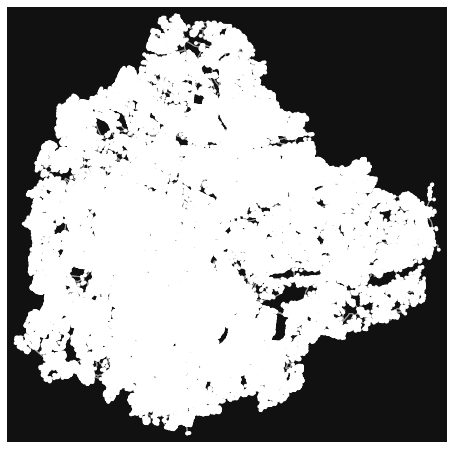

In [16]:
#My data points lie in Bangalore region. OSMnx has a cool feature where you can extract the streets graph just by inputting the region name
G= ox.graph_from_place('Bangalore, India')
fig, ax = ox.plot_graph(G)

If you prefer importing streets network graph for a specific study region/ neighborhood and have a boundary shapefile of the same,
you can uncomment and use the lines below and ignore the lines above. For more ways to import graph, check out the osmnx graph module
[here](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.graph).

In [ ]:
# boundary = "path_to_file/boundary.shp"
##Extract 
# file = ogr.Open(boundary)
# layer = file.GetLayer()
# feature = layer.GetFeature(0)
# geom= feature.GetGeometryRef()

# feature_json = geom.ExportToJson()
# loadasdict = json.loads(feature_json)
# geom2 = shape(loadasdict) 
# G = ox.graph_from_polygon(geom2)
# G2 = ox.consolidate_intersections(G, tolerance=10, rebuild_graph=True)

In [25]:
od_paths = '...filepath/OD_pairs1.csv'
df = pd.read_csv(od_paths)

The methods below are built using the directions outlined by Geoff Boeing (also the author of osmnx) [here](https://stackoverflow.com/a/58311118/7105292).

In [24]:
def nodes_to_linestring(path):
    coords_list = [(G.nodes[i]['x'], G.nodes[i]['y']) for i in path ]
    #print(coords_list)
    line = LineString(coords_list)
    
    return(line)

def shortestpath(o_lat, o_long, d_lat, d_long):
    
    nearestnode_origin, dist_o_to_onode = ox.distance.get_nearest_node(G, (o_lat, o_long), method='haversine', return_dist=True)
    nearestnode_dest, dist_d_to_dnode = ox.distance.get_nearest_node(G, (d_lat, d_long), method='haversine', return_dist=True)
    
    #Add up distance to nodes from both o and d ends. This is the distance that's not covered by the network
    dist_to_network = dist_o_to_onode + dist_d_to_dnode
    
    shortest_p = nx.shortest_path(G,nearestnode_origin, nearestnode_dest) 
    
    route = nodes_to_linestring(shortest_p) #Method defined above
    
    # Calculating length of the route requires projection into UTM system. Using 
    inSpatialRef = osr.SpatialReference()
    inSpatialRef.ImportFromEPSG(4326)
    outSpatialRef = osr.SpatialReference()
    outSpatialRef.ImportFromEPSG(32643)
    coordTransform = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)
    
    #route.wkt returns wkt of the shapely object. This step was necessary as transformation can be applied 
    #only on an ogr object. Used EPSG 32643 as Bangalore is in 43N UTM grid zone.
    geom = ogr.CreateGeometryFromWkt(route.wkt)
   
    geom.Transform(coordTransform)
    length = geom.Length()
    
    #Total length to be covered is length along network between the nodes plus the distance from the O,D points to their nearest nodes
    total_length = length + dist_to_network
    #in metres
    
    return(route, total_length )

In [26]:
df['osmnx_geometry'] = df.apply(lambda x: shortestpath(x['o_lat'], x['o_long'], x['d_lat'], x['d_long'])[0] , axis=1)
df['osmnx_length'] = df.apply(lambda x: shortestpath(x['o_lat'], x['o_long'], x['d_lat'], x['d_long'])[1] , axis=1)
df
#Note that the lambda function returns a tuple. While applying the function, have add [0] and [1] to return only one of the two outputs. 
#There must be a nicer way to add both outputs in one go. This was more of a fluke try which worked. Alternatively, you could define two functions to return both separtely, but might be an overkill

,o_id,o_long,o_lat,d_id,d_long,d_lat,osmnx_path,osmnx_length
0,o1,77.548349,12.996800,d1,77.554137,12.995225,"LINESTRING (77.5482836 12.9966618, 77.54976259...",827.718256
1,o2,77.555820,13.009082,d2,77.570458,12.995690,"LINESTRING (77.555814 13.0090627, 77.5556026 1...",2588.006507
2,o3,77.576325,13.014630,d3,77.583616,13.009188,"LINESTRING (77.57588320000001 13.0146859, 77.5...",1107.137060
3,o4,77.564848,12.990121,d4,77.551316,12.988570,"LINESTRING (77.56473080000001 12.9898858, 77.5...",1744.708360
4,o5,77.590529,12.992340,d5,77.598469,12.988289,"LINESTRING (77.5901456 12.9920295, 77.5905355 ...",1097.493520


In [27]:
#rename osmnx_path column to 'geometry' to pass it as the geometry component to the new geo dataframe
df = df.rename(columns = {'osmnx_path': 'geometry'})
gpdf = gpd.GeoDataFrame(df, geometry =df['geometry'])
gpdf.to_file('osmnx_shortestpaths.shp', ignore_index = True)


# 3. Googlemaps Directions API for routes with travel times factoring traffic

At the time of this writing, calls to the directions API yields neither the absolute shortest path nor the absolute fastest path. As per the [API documentation](https://developers.google.com/maps/documentation/directions/overview), it returns the "most-efficient" route, taking into account travel-time, distance, number of turns, and so on. However, if you are really looking for shortest route or traffic based fastest route, as pointed out by [this answer](https://stackoverflow.com/a/37844795/7105292), you can request for all alternatives and tweak the code below to select only the shortest or fastest route from all the routes returned. Do go through the documentation for info on how you can pass other parameters meaningful to your use case.

Do note that you might also need to create a Google Maps Platform billing account (separate from the Google Cloud Platform billing account) to be able to access the traffic based travel times. The monthly free credits should allow you to make considerable amount of requests. This [pricing sheet](https://cloud.google.com/maps-platform/pricing/sheet/) might help too.

In [35]:
gmaps = googlemaps.Client(key ='AI..your API key')
"""At the time of this writing, Directions API can be used for traffic-based travel times only 
when a valid Google Maps Billing account is set up and the directions API is enabled for the key supported by this account. 
Do check out the Directions API documentation for more info on other parameters that can be passed with this request.""" 

od_pairs_csv = '...filepath/OD_pairs1.csv'

df= pd.read_csv(od_pairs_csv)
df

,o_id,o_long,o_lat,d_id,d_long,d_lat
0,o1,77.548349,12.996800,d1,77.554137,12.995225
1,o2,77.555820,13.009082,d2,77.570458,12.995690
2,o3,77.576325,13.014630,d3,77.583616,13.009188
3,o4,77.564848,12.990121,d4,77.551316,12.988570
4,o5,77.590529,12.992340,d5,77.598469,12.988289


In [36]:
def get_route(pickup_lon, pickup_lat, dropoff_lon, dropoff_lat):
    origin = (pickup_lat,pickup_lon)
    dest =(dropoff_lat, dropoff_lon)
    
    directions_response = gmaps.directions(origin, dest, mode = "driving", departure_time = 1613397816) 
    # Always input a future time in epoch seconds. Can use an online converter E.g. https://www.epochconverter.com/
    return directions_response


#long, lat has to be passed in x,y format for shapely linestring object, hence 
#the tuples in the list returned by directions() function need to be inverted before constructing the linestring geometry
def reverseTuple(lstOfTuple):       
    return [tup[::-1] for tup in lstOfTuple] 


def extract_route_geom(directions_response):
    line = directions_response[0]['overview_polyline']['points']
    route = polyline.decode(line)
    reverse_tup_list = reverseTuple(route)
    return(LineString(reverse_tup_list))
    
def extract_gdis(directions_response):    
    gdis = directions_response[0]['legs'][0]['distance']['value']
    return gdis
    
def extract_gdur(directions_response):
    gdur = directions_response[0]['legs'][0]['duration']['value']
    return gdur
    
def extract_gdur_traffic(directions_response):
    gdur_traf = directions_response[0]['legs'][0]['duration_in_traffic']['value']
    return gdur_traf

In [37]:
df['responses'] = df.apply(lambda x: get_route(x['o_long'], x['o_lat'], x['d_long'], x['d_lat']), axis = 1)
df['geometry'] = df.apply(lambda x: extract_route_geom(x['responses']), axis = 1)
df['gdis'] =  df.apply(lambda x: extract_gdis(x['responses']), axis = 1)
df['gdur'] =  df.apply(lambda x: extract_gdur(x['responses']), axis = 1)
df['gdur_traffic'] =  df.apply(lambda x: extract_gdur_traffic(x['responses']), axis = 1)
df

,o_id,o_long,o_lat,d_id,d_long,d_lat,responses,geometry,gdis,gdur,gdur_traffic
0,o1,77.548349,12.996800,d1,77.554137,12.995225,"[{'bounds': {'northeast': {'lat': 12.9976708, ...","LINESTRING (77.5483 12.99681, 77.54841 12.9971...",1040,223,253
1,o2,77.555820,13.009082,d2,77.570458,12.995690,"[{'bounds': {'northeast': {'lat': 13.0106875, ...","LINESTRING (77.55584 13.00903, 77.55641 13.009...",3057,609,605
2,o3,77.576325,13.014630,d3,77.583616,13.009188,"[{'bounds': {'northeast': {'lat': 13.0147379, ...","LINESTRING (77.57632 13.01474, 77.575869999999...",1463,278,299
3,o4,77.564848,12.990121,d4,77.551316,12.988570,"[{'bounds': {'northeast': {'lat': 12.9921018, ...","LINESTRING (77.56484 12.98986, 77.564269999999...",1887,523,521
4,o5,77.590529,12.992340,d5,77.598469,12.988289,"[{'bounds': {'northeast': {'lat': 12.9923401, ...","LINESTRING (77.59054999999999 12.99234, 77.590...",1452,318,322


In [43]:
#geodataframe will not accept 'responses' as a valid field. Hence before exporting this into a geodataframe, save the entire dataframe df as a csv 
#so that 'responses' can be saved for any future analysis. (avoid re-runs at a later time)
df.to_csv('gmaps_routes_responses.csv')

df = df.drop(columns = ['responses'])
gdf = gpd.GeoDataFrame(df, geometry = df['geometry'])
gdf.to_file("gmaps_routes.shp", ignore_index=True)

# Visualise the routes extracted

Go ahead and visualise the shapefiles in QGIS or any spatial software you prefer! You can also use folium to visualise within the notebook. Here I attach an image of how these routes look. As you can see, they do not coincide.
* <b><font color = 'green'> Green lines </font></b> represent OSRM routes.
* <b><font color = 'blue'> Blue lines </font></b> represent OSMnx routes.
* <b><font color = 'red'> Red lines </font></b> represent Google Maps routes.
* Basemap used is Wikimedia Labelled Layer.

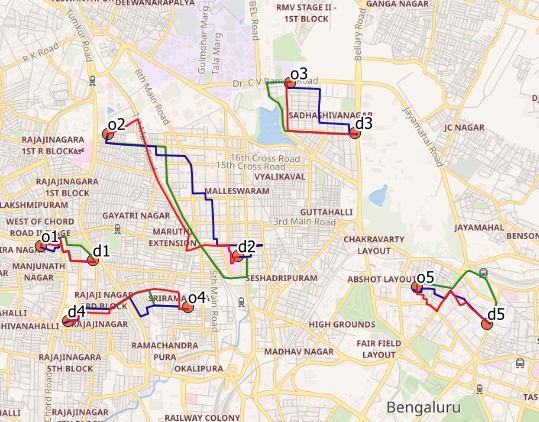